In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import json
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from scipy.optimize import curve_fit
def f(x, a): # linear function for linear regression
    return a*x

colors = sns.color_palette("coolwarm", 24)

import matplotlib

matplotlib.rcParams.update({
    'figure.dpi': 300,
    'figure.titlesize': 15,
    'axes.titlesize': 15,
    'axes.labelsize': 13,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'legend.title_fontsize': 13
})

In [16]:
casenames = os.listdir("exp1/")

In [17]:
# RMSE， MAE, mean w.r.t. OD pairs and hour of day (24 hours) and cases (each scenario has 5 days)
rmse_dist = [[],[],[],[]]
mae_dist = [[],[],[],[]]
mape_dist = [[],[],[],[]]

rmse_time = [[],[],[],[]]
mae_time = [[],[],[],[]]
mape_time = [[],[],[],[]]

# Scenario 0, 1, 2, 3
for k in range(len(casenames)):
    pathname = casenames[k]
    # get month and date
    with open('exp1/' + pathname+'/data/Data.properties', 'r', encoding='utf-8') as ff:
        _, month, day = [l for l in ff.readlines() if "DM_EVENT_FILE " in l][0].split('/')[-1].replace('.json\n','').split('-')
    day = int(day)
    if month == '01':
        continue # cannot validate this since we don't have distance data from Jan 2019
        df_fhv = pd.read_parquet("../demand_preparation/data/fhv_tripdata_2019-"+month+".parquet")
        df_fhvhv = df_fhv[df_fhv['dispatching_base_num'].isin(['B02914','B02907','B02908','B03035','B02510','B02844','B02877','B02866','B02882','B02869',\
    'B02617','B02876','B02865','B02512','B02888','B02864','B02883','B02875','B02682','B02880','B02870','B02404','B02598','B02765',\
        'B02879','B02867','B02878','B02887','B02872','B02836','B02884','B02835','B02764','B02889','B02871','B02395','B03136','B02800'])]
        df_fhvhv.rename({'dropOff_datetime':'dropoff_datetime', 'PUlocationID':'PULocationID', 'DOlocationID':'DOLocationID'}, axis = 1, inplace = True)
    else:
        df_fhvhv = pd.read_parquet("../demand_preparation/data/fhvhv_tripdata_2019-"+month+".parquet")
    df_yellow = pd.read_parquet("../demand_preparation/data/yellow_tripdata_2019-"+month+".parquet")
    df_green = pd.read_parquet("../demand_preparation/data/green_tripdata_2019-"+month+".parquet")
    df_yellow['pickup_time'] = pd.to_datetime(df_yellow['tpep_pickup_datetime'], infer_datetime_format=True)
    df_yellow['dropoff_time'] = pd.to_datetime(df_yellow['tpep_dropoff_datetime'], infer_datetime_format=True)
    df_green['pickup_time'] = pd.to_datetime(df_green['lpep_pickup_datetime'], infer_datetime_format=True)
    df_green['dropoff_time'] = pd.to_datetime(df_green['lpep_dropoff_datetime'], infer_datetime_format=True)
    # df_fhvhv['request_time'] = pd.to_datetime(df_fhvhv['request_datetime'], infer_datetime_format=True)
    df_fhvhv['pickup_time'] = pd.to_datetime(df_fhvhv['pickup_datetime'], infer_datetime_format=True)
    df_fhvhv['dropoff_time'] = pd.to_datetime(df_fhvhv['dropoff_datetime'], infer_datetime_format=True)

    df_yellow = df_yellow[(df_yellow['pickup_time'].dt.day == day)]
    df_green = df_green[ (df_green['pickup_time'].dt.day == day)]
    df_fhvhv = df_fhvhv[ (df_fhvhv['pickup_time'].dt.day == day)]
    
    ### Real observations
    df_yellow['tt'] = (df_yellow['dropoff_time'] - df_yellow['pickup_time']).dt.seconds
    df_green['tt'] = (df_green['dropoff_time'] - df_green['pickup_time']).dt.seconds 
    df_fhvhv['tt'] = (df_fhvhv['dropoff_time'] - df_fhvhv['pickup_time']).dt.seconds

    df_yellow['hour'] = df_yellow['pickup_time'].dt.hour 
    tt_yellow = df_yellow[['hour', 'tt', 'trip_distance', 'PULocationID', 'DOLocationID']].copy()

    df_green['hour'] = df_green['pickup_time'].dt.hour 
    tt_green = df_green[['hour', 'tt', 'trip_distance', 'PULocationID', 'DOLocationID']].copy()

    df_fhvhv['hour'] = df_fhvhv['pickup_time'].dt.hour 
    tt_fhvhv = df_fhvhv[['hour', 'tt', 'trip_miles', 'PULocationID', 'DOLocationID']].copy()
    tt_fhvhv.rename(columns={'trip_miles': 'trip_distance'}, inplace = True)

    tt_real = pd.concat([tt_yellow,tt_green,tt_fhvhv]).reset_index()

    tt_real = tt_real[tt_real['tt']<10800]
    tt_real = tt_real[tt_real['trip_distance']<100]
    
    ### Simulation outputs
    for filename in os.listdir("exp1/" + pathname + "/agg_output/4000_0"):
        if filename.startswith("EV"):
            df_sim = pd.read_csv("exp1/" + pathname + "/agg_output/4000_0/" + filename)
        if filename.startswith("Network"):
            df_network = pd.read_csv("exp1/" + pathname + "/agg_output/4000_0/"+filename)

    df_sim = df_sim[df_sim['tripType']==1] # get the occupied trip
    df_sim['hour'] = df_sim['departureTime']//12000
    df_sim = df_sim[df_sim['hour']<27]
    df_sim = df_sim[df_sim['hour']>=3]
    df_sim['hour'] = df_sim['hour']-3
    df_sim['tt'] = (df_sim['tick'] - df_sim['departureTime'])*0.3

    tt_sim = df_sim[['hour','tt','originID','destID','tripType', 'distance']].copy()
    
    if len(df_network) < 600:
        print("warning: " + pathname + "may be corrupted")

    # also need to match the originID, destID with taxi zone id
    df_zone = pd.read_csv("../demand_preparation/data/zone_fileNYC.csv").iloc[:,1].values

    tt_sim['pickupID'] = df_zone[tt_sim['originID'].values.astype(int)]
    tt_sim['dropoffID'] = df_zone[tt_sim['destID'].values.astype(int)]

    tt_sim.loc[tt_sim['originID']<0,'pickupID'] = -1
    tt_sim.loc[tt_sim['destID']<0,'dropoffID'] = -1

    # drop the record with -1
    tt_sim = tt_sim[(tt_sim['pickupID']>0)&(tt_sim['dropoffID']>0)]

    # tt_real['speed'] = tt_real['trip_distance'] / tt_real['tt'] *3600
    # tt_sim['speed'] = tt_sim['distance'] / (1609 * tt_sim['tt']) *3600 
    tt_sim['index'] = tt_sim.index
    real_demand = tt_real.groupby(['PULocationID','DOLocationID'])['index'].count().reset_index()
    sim_demand = tt_sim.groupby(['pickupID','dropoffID'])['index'].count().reset_index()
    mat_real = np.zeros((266,266))
    mat_real[real_demand['PULocationID'], real_demand['DOLocationID']] = real_demand['index']
    mat_sim = np.zeros((266,266))
    mat_sim[sim_demand['pickupID'], sim_demand['dropoffID']] = sim_demand['index']
    # fig, axs = plt.subplots(1,2,figsize=(8,4))
    selected_x, selected_y = np.where(mat_real>20) # As we sample 5% of the demand, the real world demand need to be greater than 20 to ensure enough observations can be generated in simulation
    tt_sim['OD'] = list(zip(tt_sim.pickupID, tt_sim.dropoffID))
    tt_real['OD'] = list(zip(tt_real.PULocationID, tt_real.DOLocationID))

    tt_real = tt_real[tt_real['OD'].isin(list(zip(selected_x,selected_y)))].reset_index(drop=True)
    tt_sim = tt_sim[tt_sim['OD'].isin(list(zip(selected_x,selected_y)))].reset_index(drop=True)

    agg_real = tt_real.groupby(['hour','PULocationID','DOLocationID']).agg({'tt':np.mean,'trip_distance':np.mean})
    agg_sim = tt_sim.groupby(['hour','pickupID','dropoffID']).agg({'tt':np.mean,'distance':np.mean, 'index':"count"})

    agg_merged = pd.merge(left = agg_real, right = agg_sim, left_on = ['hour','PULocationID','DOLocationID'],
                         right_on=['hour','pickupID','dropoffID']).reset_index()
    df_clean = agg_merged
    df_clean = df_clean[df_clean['trip_distance']>0].reset_index()
    
    # Calculate the metrics
    tmp_count = np.sum(df_clean['index'])
    tmp_dist_abs = np.sum(df_clean['index']*np.abs(df_clean.trip_distance- df_clean.distance/1609))
    tmp_time_abs = np.sum(df_clean['index']*np.abs(df_clean.tt_x - df_clean.tt_y))
    tmp_dist_squ = np.sum(df_clean['index']*(df_clean.trip_distance- df_clean.distance/1609)**2)
    tmp_time_squ = np.sum(df_clean['index']*(df_clean.tt_x - df_clean.tt_y)**2)
    tmp_dist_per = np.sum(df_clean['index']*np.abs(df_clean.trip_distance- df_clean.distance/1609)/df_clean.trip_distance)
    tmp_time_per = np.sum(df_clean['index']*np.abs(df_clean.tt_x - df_clean.tt_y)/df_clean.tt_x)
    
    rmse_dist[int(pathname.split('_')[1])].append(np.sqrt(np.sum(tmp_dist_squ)/tmp_count))
    rmse_time[int(pathname.split('_')[1])].append(np.sqrt(np.sum(tmp_time_squ)/tmp_count))
    mae_dist[int(pathname.split('_')[1])].append(np.sum(tmp_dist_abs)/tmp_count)
    mae_time[int(pathname.split('_')[1])].append(np.sum(tmp_time_abs)/tmp_count)
    mape_dist[int(pathname.split('_')[1])].append(np.sum(tmp_dist_per)/tmp_count)
    mape_time[int(pathname.split('_')[1])].append(np.sum(tmp_time_per)/tmp_count)

In [18]:
print("{} & {} & {} & {} & {}".format("", "Scenario 1", "Scenario 2", "Scenario 3", "Scenario 4"))
print("Distance RMSE (mile) & ${:.2f} \pm {:.2f}$ & ${:.2f} \pm {:.2f}$ & ${:.2f} \pm {:.2f}$ & ${:.2f} \pm {:.2f}$".\
      format(np.mean(rmse_dist[0]), np.std(rmse_dist[0]), np.mean(rmse_dist[1]), np.std(rmse_dist[1]), \
             np.mean(rmse_dist[2]), np.std(rmse_dist[2]), np.mean(rmse_dist[3][-5:]), np.std(rmse_dist[3][-5:])))
print("Distance MAE (mile) & ${:.2f} \pm {:.2f}$ & ${:.2f} \pm {:.2f}$ & ${:.2f} \pm {:.2f}$ & ${:.2f} \pm {:.2f}$".\
      format(np.mean(mae_dist[0]), np.std(mae_dist[0]), np.mean(mae_dist[1]), np.std(mae_dist[1]),\
             np.mean(mae_dist[2]), np.std(mae_dist[2]), np.mean(mae_dist[3][-5:]), np.std(mae_dist[3][-5:])))
# print("{:.2f} & {:.2f} & {:.2f} & {:.2f}".format(np.mean(mape_dist[0]), np.mean(mape_dist[1]), np.mean(mape_dist[2]), np.mean(mape_dist[3][-5:])))
print("Time RMSE (min) & ${:.2f} \pm {:.2f}$ & ${:.2f} \pm {:.2f}$ & ${:.2f} \pm {:.2f}$ & ${:.2f} \pm {:.2f}$".\
      format(np.mean(rmse_time[0])/60, np.std(rmse_time[0])/60, np.mean(rmse_time[1])/60, np.std(rmse_time[1])/60, \
             np.mean(rmse_time[2])/60, np.std(rmse_time[2])/60, np.mean(rmse_time[3][-5:])/60, np.std(rmse_time[3][-5:])/60))
print("Time MAE (min) ${:.2f} \pm {:.2f}$ & ${:.2f} \pm {:.2f}$ & ${:.2f} \pm {:.2f}$ & ${:.2f} \pm {:.2f}$".\
      format(np.mean(mae_time[0])/60, np.std(mae_time[0])/60, np.mean(mae_time[1])/60, np.std(mae_time[1])/60,\
             np.mean(mae_time[2])/60, np.std(mae_time[2])/60, np.mean(mae_time[3][-5:])/60, np.std(mae_time[3][-5:])/60))
# print("{:.2f} & {:.2f} & {:.2f} & {:.2f}".format(np.mean(mape_time[0]), np.mean(mape_time[1]), np.mean(mape_time[2]), np.mean(mape_time[3][-5:])))

 & Scenario 1 & Scenario 2 & Scenario 3 & Scenario 4
Distance RMSE (mile) & $0.97 \pm 0.05$ & $1.25 \pm 0.03$ & $1.69 \pm 0.98$ & $3.73 \pm 0.20$
Distance MAE (mile) & $0.65 \pm 0.03$ & $0.84 \pm 0.02$ & $1.09 \pm 0.56$ & $2.31 \pm 0.10$
Time RMSE (min) & $5.71 \pm 0.70$ & $5.42 \pm 1.13$ & $6.58 \pm 3.08$ & $12.62 \pm 0.43$
Time MAE (min) $4.40 \pm 0.46$ & $3.77 \pm 0.57$ & $4.63 \pm 2.00$ & $8.67 \pm 0.23$


In [19]:
# How many percentage of observations are within certain rang
for k in [0,5,10,15]:
    # ---- Part 1: process the output files ----
    pathname = casenames[k]
    # get month and date
    with open('exp1/' + pathname+'/data/Data.properties', 'r', encoding='utf-8') as ff:
        _, month, day = [l for l in ff.readlines() if "DM_EVENT_FILE " in l][0].split('/')[-1].replace('.json\n','').split('-')
    day = int(day)
    if month == '01':
        continue # cannot validate this since we don't have distance data from Jan 2019
        df_fhv = pd.read_parquet("../demand_preparation/data/fhv_tripdata_2019-"+month+".parquet")
        df_fhvhv = df_fhv[df_fhv['dispatching_base_num'].isin(['B02914','B02907','B02908','B03035','B02510','B02844','B02877','B02866','B02882','B02869',\
    'B02617','B02876','B02865','B02512','B02888','B02864','B02883','B02875','B02682','B02880','B02870','B02404','B02598','B02765',\
        'B02879','B02867','B02878','B02887','B02872','B02836','B02884','B02835','B02764','B02889','B02871','B02395','B03136','B02800'])]
        df_fhvhv.rename({'dropOff_datetime':'dropoff_datetime', 'PUlocationID':'PULocationID', 'DOlocationID':'DOLocationID'}, axis = 1, inplace = True)
    else:
        df_fhvhv = pd.read_parquet("../demand_preparation/data/fhvhv_tripdata_2019-"+month+".parquet")
        
    df_yellow = pd.read_parquet("../demand_preparation/data/yellow_tripdata_2019-"+month+".parquet")
    df_green = pd.read_parquet("../demand_preparation/data/green_tripdata_2019-"+month+".parquet")
    df_yellow['pickup_time'] = pd.to_datetime(df_yellow['tpep_pickup_datetime'], infer_datetime_format=True)
    df_yellow['dropoff_time'] = pd.to_datetime(df_yellow['tpep_dropoff_datetime'], infer_datetime_format=True)
    df_green['pickup_time'] = pd.to_datetime(df_green['lpep_pickup_datetime'], infer_datetime_format=True)
    df_green['dropoff_time'] = pd.to_datetime(df_green['lpep_dropoff_datetime'], infer_datetime_format=True)
    df_fhvhv['pickup_time'] = pd.to_datetime(df_fhvhv['pickup_datetime'], infer_datetime_format=True)
    df_fhvhv['dropoff_time'] = pd.to_datetime(df_fhvhv['dropoff_datetime'], infer_datetime_format=True)
    df_yellow = df_yellow[(df_yellow['pickup_time'].dt.day == day)]
    df_green = df_green[ (df_green['pickup_time'].dt.day == day)]
    df_fhvhv = df_fhvhv[ (df_fhvhv['pickup_time'].dt.day == day)]
    # Obtain travel time
    ### Real observations
    df_yellow['tt'] = (df_yellow['dropoff_time'] - df_yellow['pickup_time']).dt.seconds
    df_green['tt'] = (df_green['dropoff_time'] - df_green['pickup_time']).dt.seconds 
    df_fhvhv['tt'] = (df_fhvhv['dropoff_time'] - df_fhvhv['pickup_time']).dt.seconds
    df_yellow['hour'] = df_yellow['pickup_time'].dt.hour 
    tt_yellow = df_yellow[['hour', 'tt', 'trip_distance', 'PULocationID', 'DOLocationID']].copy()
    df_green['hour'] = df_green['pickup_time'].dt.hour 
    tt_green = df_green[['hour', 'tt', 'trip_distance', 'PULocationID', 'DOLocationID']].copy()
    df_fhvhv['hour'] = df_fhvhv['pickup_time'].dt.hour 
    tt_fhvhv = df_fhvhv[['hour', 'tt', 'trip_miles', 'PULocationID', 'DOLocationID']].copy()
    tt_fhvhv.rename(columns={'trip_miles': 'trip_distance'}, inplace = True)
    tt_real = pd.concat([tt_yellow,tt_green,tt_fhvhv]).reset_index()
    tt_real = tt_real[tt_real['tt']<10800]
    tt_real = tt_real[tt_real['trip_distance']<100]
    ### Simulation outputs
    for filename in os.listdir("exp1/" + pathname + "/agg_output/4000_0"):
        if filename.startswith("EV"):
            df_sim = pd.read_csv("exp1/" + pathname + "/agg_output/4000_0/" + filename)

    df_sim = df_sim[df_sim['tripType']==1] # get the occupied trip
    df_sim['hour'] = df_sim['departureTime']//12000
    df_sim = df_sim[df_sim['hour']<27]
    df_sim = df_sim[df_sim['hour']>=3]
    df_sim['hour'] = df_sim['hour']-3
    df_sim['tt'] = (df_sim['tick'] - df_sim['departureTime'])*0.3
    tt_sim = df_sim[['hour','tt','originID','destID','tripType', 'distance']].copy()
    # also need to match the originID, destID with taxi zone id
    df_zone = pd.read_csv("../demand_preparation/data/zone_fileNYC.csv").iloc[:,1].values
    tt_sim['pickupID'] = df_zone[tt_sim['originID'].values.astype(int)]
    tt_sim['dropoffID'] = df_zone[tt_sim['destID'].values.astype(int)]
    tt_sim.loc[tt_sim['originID']<0,'pickupID'] = -1
    tt_sim.loc[tt_sim['destID']<0,'dropoffID'] = -1
    # drop the record with -1
    tt_sim = tt_sim[(tt_sim['pickupID']>=0)&(tt_sim['dropoffID']>=0)]
    tt_sim['index'] = tt_sim.index
    real_demand = tt_real.groupby(['PULocationID','DOLocationID'])['index'].count().reset_index()
    sim_demand = tt_sim.groupby(['pickupID','dropoffID'])['index'].count().reset_index()
    mat_real = np.zeros((266,266))
    mat_real[real_demand['PULocationID'], real_demand['DOLocationID']] = real_demand['index']
    mat_sim = np.zeros((266,266))
    mat_sim[sim_demand['pickupID'], sim_demand['dropoffID']] = sim_demand['index']
    selected_x, selected_y = np.where(mat_real>20)
    tt_sim['OD'] = list(zip(tt_sim.pickupID, tt_sim.dropoffID))
    tt_real['OD'] = list(zip(tt_real.PULocationID, tt_real.DOLocationID))
    tt_real = tt_real[tt_real['OD'].isin(list(zip(selected_x,selected_y)))].reset_index(drop=True)
    tt_sim = tt_sim[tt_sim['OD'].isin(list(zip(selected_x,selected_y)))].reset_index(drop=True)
    agg_real = tt_real.groupby(['hour','PULocationID','DOLocationID']).agg({'tt':np.mean,'trip_distance':np.mean})
    agg_sim = tt_sim.groupby(['hour','pickupID','dropoffID']).agg({'tt':np.mean,'distance':np.mean,'index':"count"})
    agg_merged = pd.merge(left = agg_real, right = agg_sim, left_on = ['hour','PULocationID','DOLocationID'],
                         right_on=['hour','pickupID','dropoffID']).reset_index()
    df_clean = agg_merged[agg_merged['trip_distance']>0].reset_index()
    
    # Report two values, how many OxDxhour pairs falls within 10 min and how many falls within 2 miles
    tmp_count = np.sum(df_clean['index'])
    tmp_time_od = np.sum((np.abs(df_clean.tt_x - df_clean.tt_y)/60)<=10)/len(df_clean)
    tmp_dist_od = np.sum((np.abs(df_clean.trip_distance- df_clean.distance/1609)<=3))/len(df_clean)
    
    tmp_time_demand = np.sum(df_clean['index']*((np.abs(df_clean.tt_x - df_clean.tt_y)/60)<=10))/tmp_count
    tmp_dist_demand = np.sum(df_clean['index']*(np.abs(df_clean.trip_distance- df_clean.distance/1609)<=3))/tmp_count
    
    # ---------------------------- Figure 1 ------------------------------------ #
    # first overall comparison, x-observed travel time for each OD pair, y-corresponding sim travel time
    fig, ax = plt.subplots(figsize = (4,3))

    for i in range(24):
        plt.plot(df_clean[df_clean.hour == i].tt_x, df_clean[df_clean.hour == i].tt_y, '.', markersize = 1, alpha = 0.5, color = colors[i%24])
    
    popt, pcov = curve_fit(f, df_clean.tt_x, df_clean.tt_y)

    # add linear regression line to scatterplot 
    tt_x = np.arange(0,7200,60)
    plt.plot(tt_x, f(tt_x, *popt))
    plt.plot(tt_x,tt_x,'--',color = 'black')
    
    # add shaded area
    plt.fill_between(tt_x, tt_x-600, tt_x+600, color = 'lightgrey', alpha=0.3)

    # calculate the R-squared
    y = df_clean.tt_y
    y_fit =  f(df_clean.tt_x, *popt)
    ss_res = np.sum((y - y_fit) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    plt.text(x = 4000, y = 1500, \
             s = "$y = {:.2f}x$, $R^2 = {:.2f}$ \nShaded area covers:\n {:.0%} OD pairs\n {:.0%} trips".\
             format(popt[0],r2,tmp_time_od,tmp_time_demand), fontsize=8)

    plt.xlim([0,7200])
    plt.ylim([0,7200])

    plt.xticks(np.arange(0,7201,900), np.arange(0,121,15))
    plt.yticks(np.arange(0,7201,900), np.arange(0,121,15))

    plt.xlabel("Real trip time (min)")
    plt.ylabel("Simulated trip time (min)")

    plt.title("Scenario {} Case {}".format(k//5+1, k % 5 + 1))
    plt.tight_layout()
    plt.savefig("fig/exp1/trip_time_scatter_"+str(k) + ".png")
    plt.savefig("fig/exp1/trip_time_scatter_"+str(k) + ".pdf")
    plt.close()
    
    # ---------------------------- Figure 2 ------------------------------------ #
    fig, ax = plt.subplots(figsize = (4,3))

    for i in range(24):
        plt.plot(df_clean[df_clean.hour == i].trip_distance, df_clean[df_clean.hour == i].distance/1609, '.', markersize = 1, alpha = 0.5, color = colors[i%24])

    popt, pcov = curve_fit(f, df_clean.trip_distance, df_clean.distance/1609)

    #add linear regression line to scatterplot 
    trip_distance = np.arange(0,40,1)
    plt.plot(trip_distance, f(trip_distance, *popt))
    plt.plot(trip_distance,trip_distance,'--',color = 'black')
    
    # add shaded area
    plt.fill_between(trip_distance, trip_distance-3, trip_distance+3, color = 'lightgrey', alpha=0.3)

    # calculate the R-squared
    y = df_clean.distance/1609
    y_fit =  f(df_clean.trip_distance, *popt)
    ss_res = np.sum((y - y_fit) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    plt.text(x = 20, y = 7.5, \
             s = "$y = {:.2f}x$, $R^2 = {:.2f}$ \nShaded area covers:\n {:.0%} OD pairs\n {:.0%} trips".\
             format(popt[0],r2,tmp_dist_od,tmp_dist_demand), fontsize=8)

    plt.xlim([0,40])
    plt.ylim([0,40])

    plt.xlabel("Real trip distance (miles)")
    plt.ylabel("Simulated trip distance (miles)")

    plt.title("Scenario {} Case {}".format(k//5+1, k % 5 + 1))
    plt.tight_layout()
    plt.savefig("fig/exp1/trip_distance_scatter_"+str(k) + ".png")
    plt.savefig("fig/exp1/trip_distance_scatter_"+str(k) + ".pdf")
    plt.close()
    
    # Temporal comparison
    agg_real = tt_real.groupby(['hour']).agg({'tt':np.sum,'trip_distance':np.sum})
    agg_sim = tt_sim.groupby(['hour']).agg({'tt':np.sum,'distance':np.sum})

    agg_merged = pd.merge(left = agg_real, right = agg_sim, left_on = ['hour'],
                         right_on=['hour']).reset_index()

    df_clean = agg_merged
    
    # ---------------------------- Figure 3 ------------------------------------ #
    fig, ax = plt.subplots(figsize = (4,3))

    plt.plot(df_clean.hour, df_clean.tt_x/60 / (np.max(df_clean.tt_x/60)), '-', label = r'$Real$')
    plt.plot(df_clean.hour, 20*df_clean.tt_y/60 / (np.max(df_clean.tt_x/60)), '--', label = r'$Simulation \times 20$')

    plt.ylabel("Normalized total trip time")
    plt.xlabel("Hour")
    plt.title("Scenario {} Case {}".format(k//5+1, k % 5 + 1))
    plt.ylim([0,1.4])
    plt.xlim([0,24])
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.savefig("fig/exp1/trip_time_agg_"+str(k) + ".png")
    plt.savefig("fig/exp1/trip_time_agg_"+str(k) + ".pdf")
    plt.close()
    
    # ---------------------------- Figure 4 ------------------------------------ #
    fig, ax = plt.subplots(figsize = (4,3))

    plt.plot(df_clean.hour, df_clean.trip_distance / (np.max(df_clean.trip_distance)), '-', label = r'$Real$')
    plt.plot(df_clean.hour, 20*df_clean.distance/1609 / (np.max(df_clean.trip_distance)), '--', label = r'$Simulation \times 20$')

    plt.ylabel("Normalized total trip distance")
    plt.xlabel("Hour")
    plt.title("Scenario {} Case {}".format(k//5+1, k % 5 + 1))
    plt.xlim([0,24])
    plt.ylim([0,1.4])
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.savefig("fig/exp1/trip_distance_agg_"+str(k) + ".png")
    plt.savefig("fig/exp1/trip_distance_agg_"+str(k) + ".pdf")
    plt.close()

# Distribution of waiting time

In [597]:
df_fhvhv['pt'] = (df_fhvhv['pickup_datetime'] - df_fhvhv['request_datetime']).dt.seconds

In [598]:
# Get a subset of passenger from/to the hub
hub_fhvhv = df_fhvhv[(df_fhvhv['PULocationID'].isin([132, 138, 186])) | (df_fhvhv['DOLocationID'].isin([132, 138, 186]))]

In [599]:
# remove anomalies
hub_fhvhv = hub_fhvhv[(hub_fhvhv['pt'] < np.mean(hub_fhvhv['pt']) + 3*np.std(hub_fhvhv['pt']))]

In [605]:
pt_by_hour = hub_fhvhv.groupby(['hour'])['pt'].apply(lambda x: np.percentile(x,90))

In [608]:
import seaborn as sns

In [613]:
print(list((pt_by_hour.values.astype(int))))

[1031, 796, 522, 496, 457, 432, 430, 476, 530, 534, 597, 528, 504, 504, 527, 587, 553, 578, 791, 667, 658, 653, 808, 772, 738, 585, 527, 495, 459, 437, 440, 460, 527, 559, 588, 649, 548, 539, 561, 583, 621, 809, 1007, 1049, 1124, 804, 963, 900]


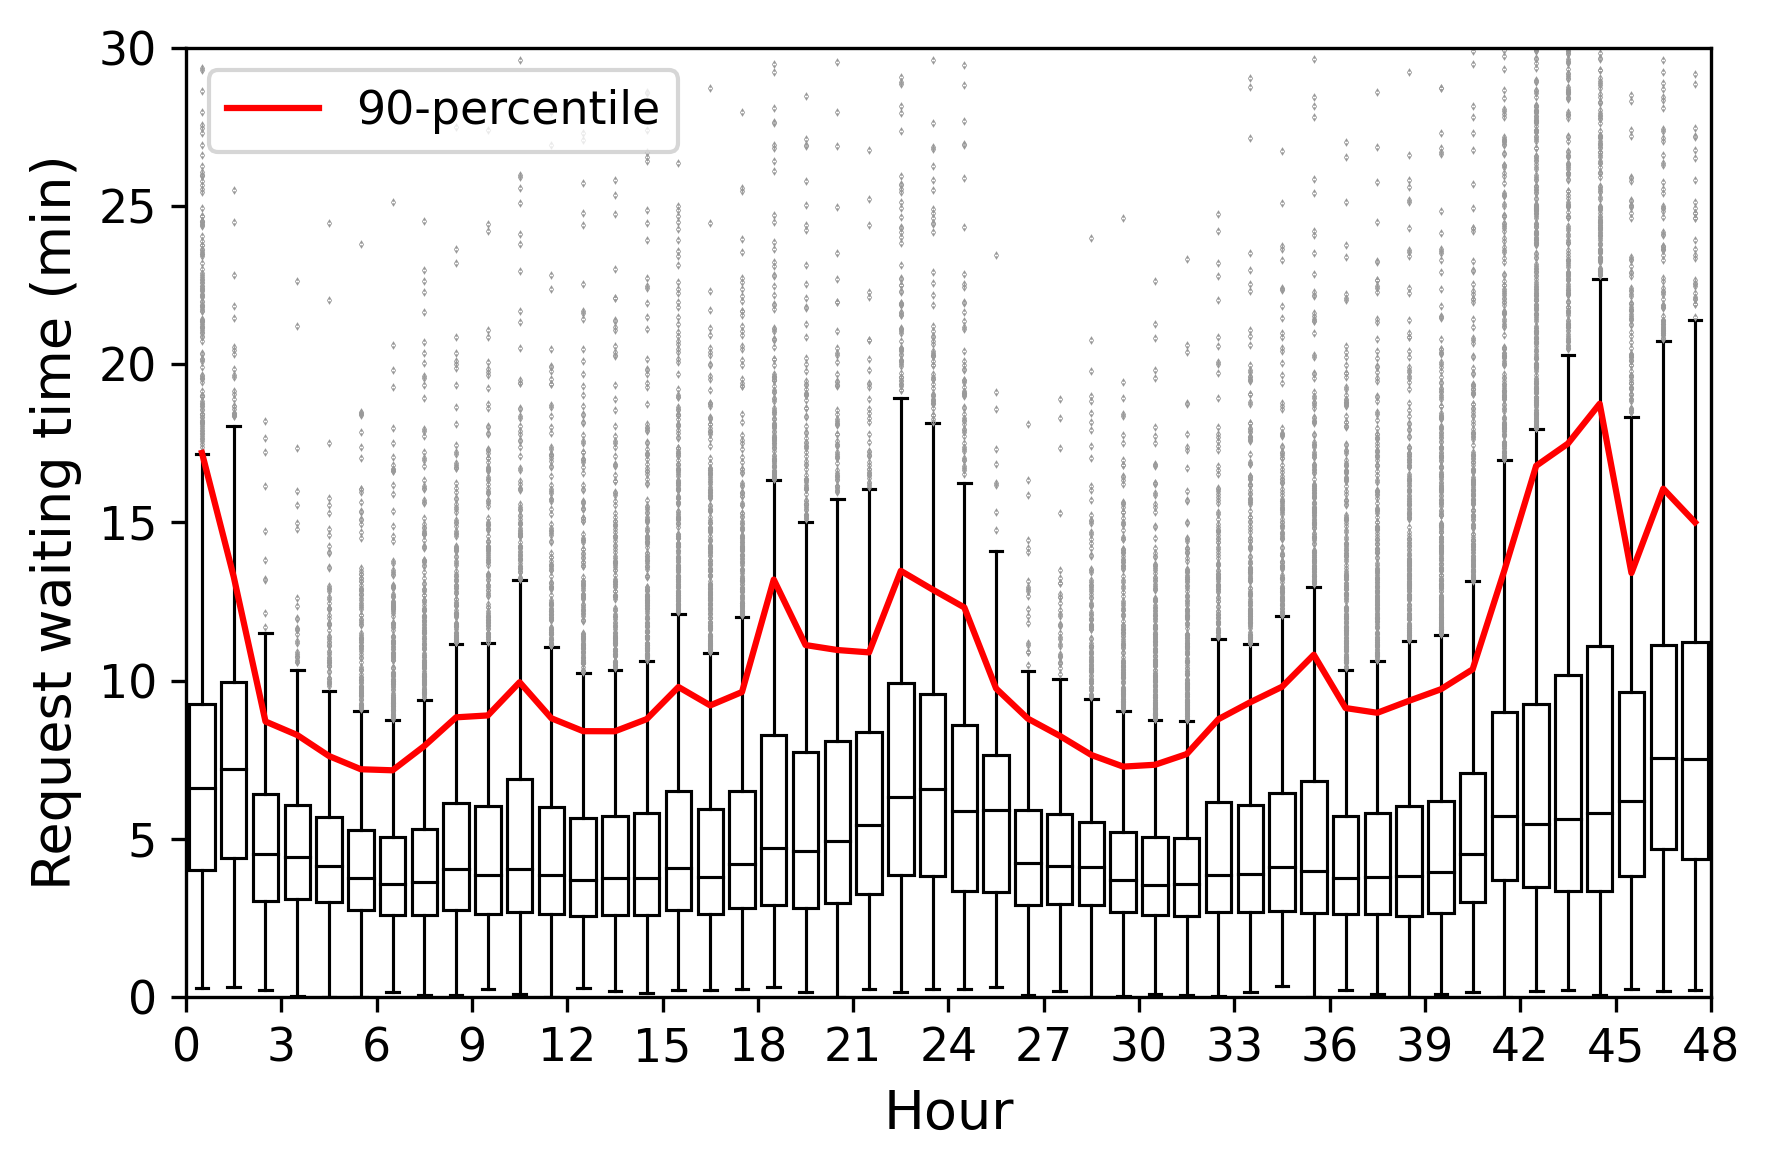

In [1186]:
plt.subplots(figsize = (6,4))

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

sns.boxplot(x='hour', y = 'pt', data=hub_fhvhv, color = 'white', fliersize=0.1, linewidth=0.75, **PROPS)
plt.plot(np.arange(48), pt_by_hour, color = 'red', label="90-percentile")

plt.ylim([0,1800])

plt.xticks(np.arange(-0.5,48.5,3), np.arange(0,49,3))

plt.yticks(np.arange(0,1801, 300),np.arange(0,31, 5))

plt.xlabel("Hour")

plt.ylabel("Request waiting time (min)")

plt.legend()

plt.tight_layout()

plt.savefig("figs/req_waiting_time.png")
plt.savefig("figs/req_waiting_time.pdf")

/home/umni2/a/umnilab/users/lei67/Anaconda3/anaconda3/envs/pt38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Waiting time (s) distribution for ride-hailing services')

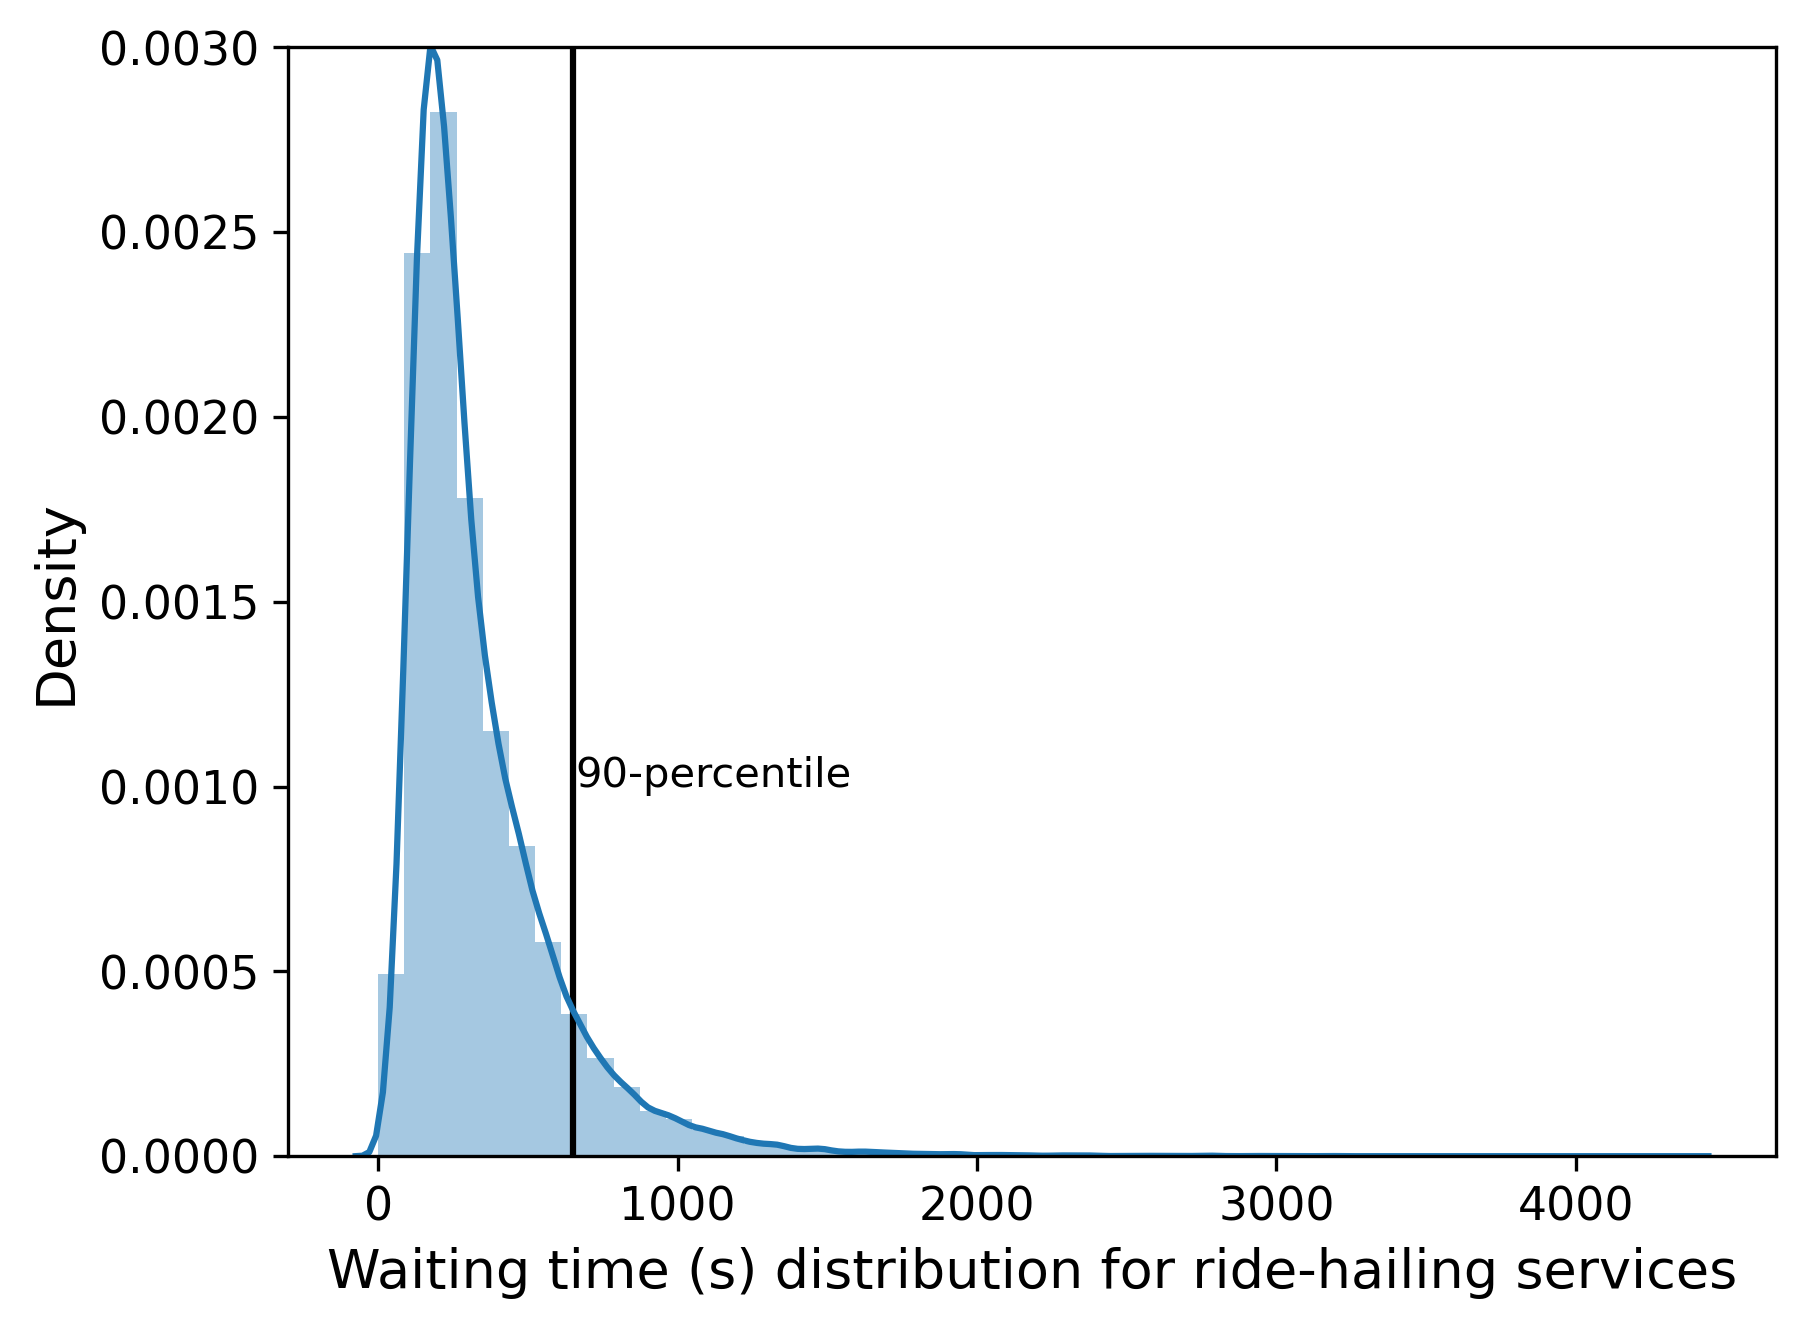

In [1185]:
sns.distplot(hub_fhvhv['pt'])

plt.vlines(x = 651, ymin = 0, ymax = 1)

plt.ylim([0,0.003])

plt.text(660, 0.001, '90-percentile')

plt.xlabel("Waiting time (s) distribution for ride-hailing services")